# TTT Gradient Analysis
Comparing surrogate vs non-surrogate gradients for k, q, v inputs.

## Tradeoff
The fundamental tradeoff of the new method is that it does not teach the network multi-step composition.

In other words it does not learn to, given future changes to the state, how to adjust the current state to meet a future target state.


It does however learn single degree composition, that is, given a future state, and it's target how can I change my current state to get closer?

The transformer on the other hand, can do neither.

In [4]:
import os
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax import nnx
from flax.nnx import rnglib as rng

sys.path.insert(0, '../../..')

from ueaj.model.ttt import TTTModel
from ueaj.model import GMLP

W1214 03:37:23.176968 1282955 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1214 03:37:23.182523 1282241 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [5]:
# Config
model_d, hidden_d = 1024, 768
batch_size, seq_len = 1, 768
seed = 42


def sample_distribution(key, shape):
	b = 3  # b=3 gives variance=1 with no scaling needed!
	key1, key2 = jax.random.split(key)
	samples = (jax.random.pareto(key1, b, shape) - 1) * jax.random.rademacher(key2, shape)
	return samples

In [16]:
# Create models
model_surr = TTTModel(model_d, hidden_d, GMLP, surrogate=True, block_size=16, rngs=rng.Rngs(seed))
model_nonsurr = TTTModel(model_d, hidden_d, GMLP, surrogate=False,  rngs=rng.Rngs(seed))

# Generate k, q, v directly
key = jax.random.PRNGKey(300)
k_key, v_key, q_key = jax.random.split(key, 3)
k = sample_distribution(k_key, (batch_size, seq_len, hidden_d))
v = sample_distribution(v_key, (batch_size, seq_len, hidden_d))
q = sample_distribution(q_key, (batch_size, seq_len, hidden_d))

print(f"k, v, q shapes: {k.shape}, {v.dtype}")
jnp.sqrt(jnp.square(k).mean())

k, v, q shapes: (1, 768, 512), float32


Array(0.97116685, dtype=float32)

In [17]:
@jax.jit
def compute_grads(model, k, v, q, grad_output):
	"""Compute gradients w.r.t. k, v, q and init_state using VJP."""
	init_state = nnx.state(model.inner_module)

	def forward(k, v, q, state):
		output, final_state = model.ttt_fn(k, v, q, state)
		return output, final_state

	# grad_output is for output, zeros for final_state
	grad_final_state = jax.tree.map(
		lambda v: sample_distribution(jax.random.PRNGKey(1000 * v[(0,) * len(v.shape)].astype(jnp.int32)), v.shape)[None, ...].astype(v.dtype), init_state)
	# grad_final_state = jax.tree.map(jnp.zeros_like, init_state)

	(output, final_state), vjp_fn = jax.vjp(forward, k, v, q, init_state)
	grad_k, grad_v, grad_q, grad_init_state = vjp_fn((grad_output, grad_final_state))
	return grad_k, grad_v, grad_q, grad_init_state, output


def rms_error_per_token(grad_surr, grad_nonsurr):
	"""Compute RMS error per token position, averaged over batch."""
	diff = grad_surr - grad_nonsurr
	rms_per_batch = jnp.sqrt(jnp.mean(diff ** 2, axis=2))  # (batch, seq_len)
	return rms_per_batch.mean(axis=0)  # (seq_len,)


def rms_norm_per_token(grad):
	"""Compute RMS norm per token position, averaged over batch."""
	rms_per_batch = jnp.sqrt(jnp.mean(grad ** 2, axis=2))  # (batch, seq_len)
	return rms_per_batch.mean(axis=0)  # (seq_len,)


def cosine_similarity_per_token(grad_surr, grad_nonsurr):
	"""Compute cosine similarity per token position, averaged over batch."""
	dot_product = jnp.sum(grad_surr * grad_nonsurr, axis=2)  # (batch, seq_len)
	norm_surr = jnp.linalg.norm(grad_surr, axis=2)  # (batch, seq_len)
	norm_nonsurr = jnp.linalg.norm(grad_nonsurr, axis=2)  # (batch, seq_len)
	cosine_sim = dot_product / (norm_surr * norm_nonsurr + 1e-8)  # (batch, seq_len)
	return cosine_sim.mean(axis=0)  # (seq_len,)


def cosine_similarity_states(state_surr, state_nonsurr):
	"""Compute cosine similarity between two state pytrees (flattened)."""
	flat_surr = jnp.concatenate([x.ravel() for x in jax.tree.leaves(state_surr)])
	flat_nonsurr = jnp.concatenate([x.ravel() for x in jax.tree.leaves(state_nonsurr)])
	dot = jnp.sum(flat_surr * flat_nonsurr)
	norm_surr = jnp.linalg.norm(flat_surr)
	norm_nonsurr = jnp.linalg.norm(flat_nonsurr)
	return float(dot / (norm_surr * norm_nonsurr + 1e-8))

In [18]:
# Random output gradient
grad_output = jax.random.normal(jax.random.PRNGKey(456), (batch_size, seq_len, hidden_d))

# Compute gradients
print("Computing gradients...")
gk_surr, gv_surr, gq_surr, gstate_surr, _ = compute_grads(model_surr, k, v, q, grad_output)
gk_nonsurr, gv_nonsurr, gq_nonsurr, gstate_nonsurr, _ = compute_grads(model_nonsurr, k, v, q, grad_output)
print("Done")

# Compute cosine similarity for init_state gradient
cos_init_state = cosine_similarity_states(gstate_surr, gstate_nonsurr)
angle_init_state = np.degrees(np.arccos(cos_init_state))
print(f"\nd_init_state cosine similarity: {cos_init_state:.4f}")
print(f"d_init_state angle: {angle_init_state:.2f} degrees")

Computing gradients...
Done

d_init_state cosine similarity: 0.0874
d_init_state angle: 84.99 degrees


In [19]:
# Compute metrics per token
cos_k = cosine_similarity_per_token(gk_surr, gk_nonsurr)
cos_v = cosine_similarity_per_token(gv_surr, gv_nonsurr)
cos_q = cosine_similarity_per_token(gq_surr, gq_nonsurr)
rms_q = rms_error_per_token(gq_surr, gq_nonsurr)

norm_q = rms_norm_per_token(gq_nonsurr)

print(f"Cosine similarity ranges:")
print(f"  k: [{float(cos_k.min()):.4f}, {float(cos_k.max()):.4f}]")
print(f"  v: [{float(cos_v.min()):.4f}, {float(cos_v.max()):.4f}]")
print(f"  q: [{float(cos_q.min()):.4f}, {float(cos_q.max()):.4f}]")
print(f"RMS error range:")
print(f"  q: [{float(rms_q.min()):.4f}, {float(rms_q.max()):.4f}]")

Cosine similarity ranges:
  k: [-0.4920, 0.9424]
  v: [-0.1666, 0.9404]
  q: [0.9981, 1.0000]
RMS error range:
  q: [0.0000, 0.0309]


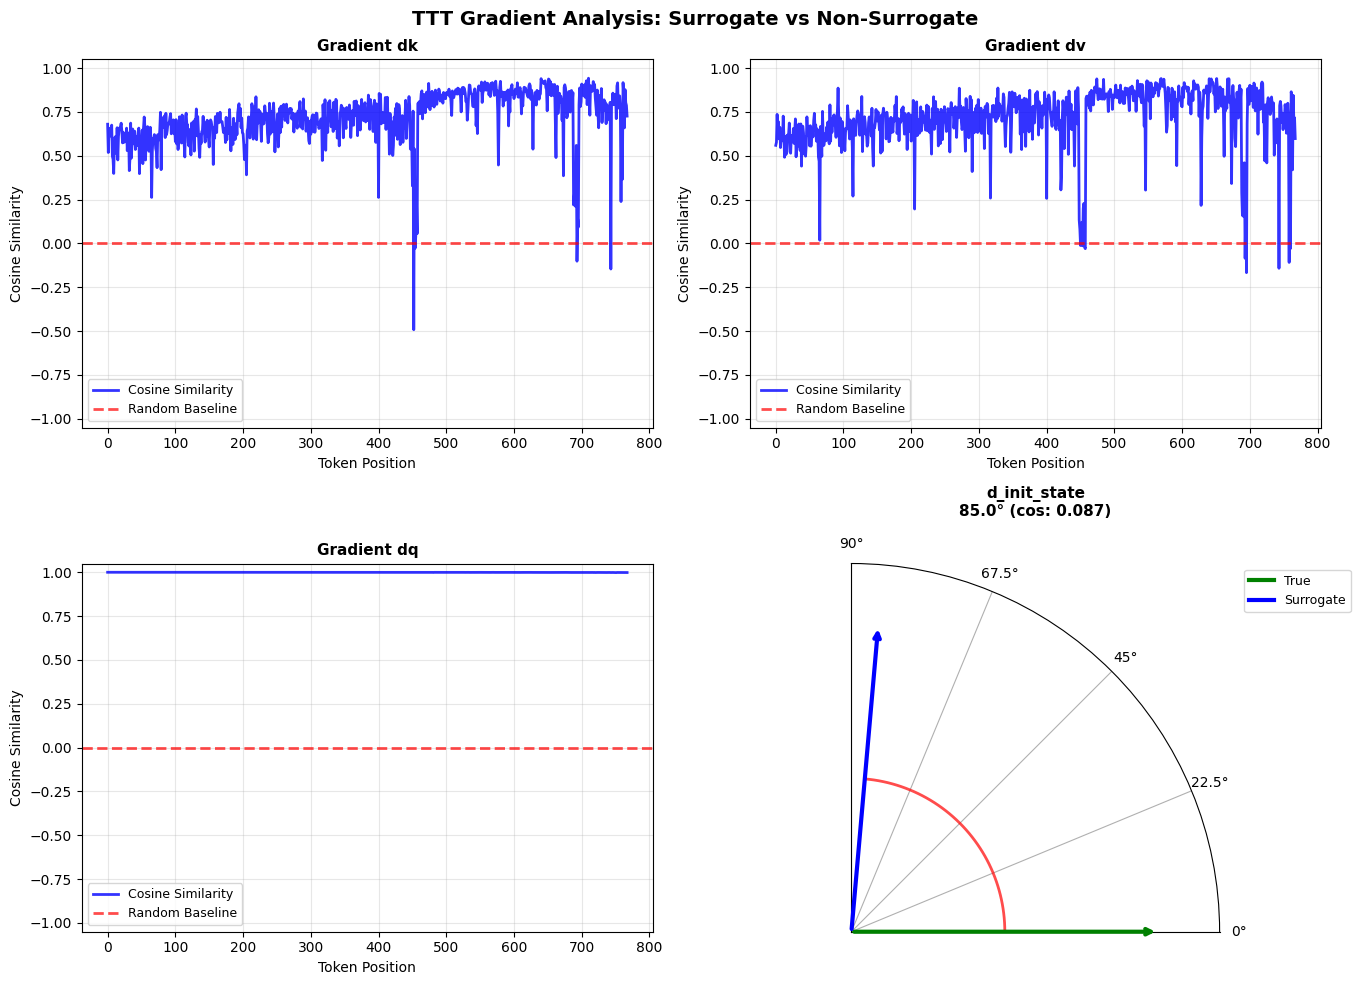

Saved as 'ttt_gradient_comparison.png'


In [20]:
# Plot all gradient comparisons including d_init_state
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(14, 10))
fig.suptitle('TTT Gradient Analysis: Surrogate vs Non-Surrogate', fontsize=14, fontweight='bold')

tokens = np.arange(seq_len)

# dk: Cosine similarity
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(tokens, cos_k, 'b-', linewidth=2, label='Cosine Similarity', alpha=0.8)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Random Baseline', alpha=0.7)
ax1.set_xlabel('Token Position', fontsize=10)
ax1.set_ylabel('Cosine Similarity', fontsize=10)
ax1.set_title('Gradient dk', fontsize=11, fontweight='bold')
ax1.set_ylim(-1.05, 1.05)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# dv: Cosine similarity
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(tokens, cos_v, 'b-', linewidth=2, label='Cosine Similarity', alpha=0.8)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Random Baseline', alpha=0.7)
ax2.set_xlabel('Token Position', fontsize=10)
ax2.set_ylabel('Cosine Similarity', fontsize=10)
ax2.set_title('Gradient dv', fontsize=11, fontweight='bold')
ax2.set_ylim(-1.05, 1.05)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# dq: Cosine similarity (changed from RMS error)
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(tokens, cos_q, 'b-', linewidth=2, label='Cosine Similarity', alpha=0.8)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Random Baseline', alpha=0.7)
ax3.set_xlabel('Token Position', fontsize=10)
ax3.set_ylabel('Cosine Similarity', fontsize=10)
ax3.set_title('Gradient dq', fontsize=11, fontweight='bold')
ax3.set_ylim(-1.05, 1.05)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# d_init_state: Polar chart
ax4 = fig.add_subplot(2, 2, 4, projection='polar')
angle_rad = np.radians(angle_init_state)

# Draw arrows
ax4.annotate('', xy=(0, 1), xytext=(0, 0),
			 arrowprops=dict(arrowstyle='->', color='green', lw=3))
ax4.annotate('', xy=(angle_rad, 1), xytext=(0, 0),
			 arrowprops=dict(arrowstyle='->', color='blue', lw=3))

# Draw arc
theta_arc = np.linspace(0, angle_rad, 50)
ax4.plot(theta_arc, [0.5] * len(theta_arc), 'r-', lw=2, alpha=0.7)

ax4.set_title(f'd_init_state\n{angle_init_state:.1f}° (cos: {cos_init_state:.3f})',
			  fontsize=11, fontweight='bold', pad=15)
ax4.set_ylim(0, 1.2)
ax4.set_yticks([])
ax4.set_xticks(np.linspace(0, np.pi / 2, 5))
ax4.set_xticklabels(['0°', '22.5°', '45°', '67.5°', '90°'])
ax4.set_thetamin(0)
ax4.set_thetamax(90)

legend_elements = [
	Line2D([0], [0], color='green', lw=3, label='True'),
	Line2D([0], [0], color='blue', lw=3, label='Surrogate'),
]
ax4.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9)

plt.tight_layout()
plt.savefig('ttt_gradient_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved as 'ttt_gradient_comparison.png'")

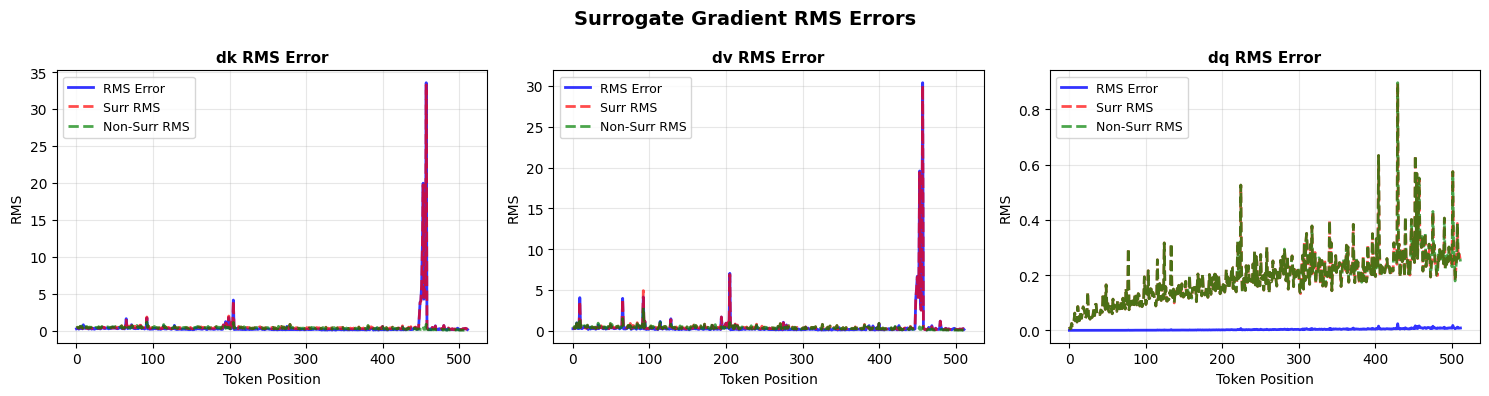

✓ Saved as 'ttt_gradient_rms_errors.png'


In [10]:
# Plot RMS errors for dk, dv, and dq with surrogate and non-surrogate RMS for scale
rms_k = rms_error_per_token(gk_surr, gk_nonsurr)
rms_v = rms_error_per_token(gv_surr, gv_nonsurr)
rms_q = rms_error_per_token(gq_surr, gq_nonsurr)
norm_k_surr = rms_norm_per_token(gk_surr)
norm_v_surr = rms_norm_per_token(gv_surr)
norm_q_surr = rms_norm_per_token(gq_surr)
norm_k_nonsurr = rms_norm_per_token(gk_nonsurr)
norm_v_nonsurr = rms_norm_per_token(gv_nonsurr)
norm_q_nonsurr = rms_norm_per_token(gq_nonsurr)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Surrogate Gradient RMS Errors', fontsize=14, fontweight='bold')

tokens = np.arange(seq_len)

# dk RMS error
axes[0].plot(tokens, rms_k, 'b-', linewidth=2, label='RMS Error', alpha=0.8)
axes[0].plot(tokens, norm_k_surr, 'r--', linewidth=2, label='Surr RMS', alpha=0.7)
axes[0].plot(tokens, norm_k_nonsurr, 'g--', linewidth=2, label='Non-Surr RMS', alpha=0.7)
axes[0].set_xlabel('Token Position', fontsize=10)
axes[0].set_ylabel('RMS', fontsize=10)
axes[0].set_title('dk RMS Error', fontsize=11, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# dv RMS error
axes[1].plot(tokens, rms_v, 'b-', linewidth=2, label='RMS Error', alpha=0.8)
axes[1].plot(tokens, norm_v_surr, 'r--', linewidth=2, label='Surr RMS', alpha=0.7)
axes[1].plot(tokens, norm_v_nonsurr, 'g--', linewidth=2, label='Non-Surr RMS', alpha=0.7)
axes[1].set_xlabel('Token Position', fontsize=10)
axes[1].set_ylabel('RMS', fontsize=10)
axes[1].set_title('dv RMS Error', fontsize=11, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# dq RMS error (new)
axes[2].plot(tokens, rms_q, 'b-', linewidth=2, label='RMS Error', alpha=0.8)
axes[2].plot(tokens, norm_q_surr, 'r--', linewidth=2, label='Surr RMS', alpha=0.7)
axes[2].plot(tokens, norm_q_nonsurr, 'g--', linewidth=2, label='Non-Surr RMS', alpha=0.7)
axes[2].set_xlabel('Token Position', fontsize=10)
axes[2].set_ylabel('RMS', fontsize=10)
axes[2].set_title('dq RMS Error', fontsize=11, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ttt_gradient_rms_errors.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved as 'ttt_gradient_rms_errors.png'")